# Predicción de prestamos bancarios con Gradient Tree Boosting

El [aprendizaje automático](https://es.wikipedia.org/wiki/Aprendizaje_autom%C3%A1tico) se está consolidando como un campo con un gran número de aplicaciones reales, que van de [sistemas de perfilado de autor en texto](https://github.com/alonsopg/AuthorProfiling) hasta detección de fraudes bancarios, o de sistemas capaces de detectar cáncer a sistemas que pueden estimar el riesgo de un seguro.

Otro dominio de aplicación del aprendizaje automático es la predicción de pago en prestamos personales:

* Es común que los bancos realicen prestamos basados en los perfiles demograficos y socieconomicos de los solicitantes de creditos financieros. 

* Para minimizar la pérdida posibles perdidas monetarias, el banco necesita saber a quién darle la aprobación del préstamo y a quien no hacerlo. 

## Los datos

El [German Credit Dataset](https://onlinecourses.science.psu.edu/stat857/node/215) contiene 20 variables para clasificar si un solicitante es buen o mal prospecto de credito financiero, la descripción del dataset puede ser encontrada en esta [liga](https://onlinecourses.science.psu.edu/stat857/node/222). Un modelo predictivo desarrollado a partir de estos datos será capaz de ayudarle a un banco decidir si debe aprobarle un prestamo a un solicitante dado su perfil.


<img src="files/loan.png"alt="Drawing" style="width: 200px;">

## Boosting

Muchos algoritmos como AdaBoost, LogitBoost, BrownBoost, XGboost usan una técnica llamada **boosting** para reducir el sesgo y la varianza en problemas de aprendizaje supervisado. En [Schapire, 1990](http://www.cs.princeton.edu/~schapire/papers/strengthofweak.pdf), se propone un proceso para convertir un estimador con bajo poder predictivo en un estimador con alto poder predictivo, mediante el uso de una metodología que se basa en iterativamente construir estimadores débiles respecto a una distribución, agregándolos a un clasificador final que tendrá un alto poder predictivo. En otras palabras, los estimadores débiles se construyen de forma secuencial y uno trata de reducir el sesgo del estimador combinado, es decir estamos combinando varios modelos débiles para producir un modelo más poderoso.

<img src="files/adaboost.png">



Boosting también es una técnica de ensemble que consiste en una mezcla de expertos. A diferencia de modelos como RF, boosting aprende estos ensembles de manera secuencial, cada miembro de este ensemble esta basado en los errores de su ensemble predecesor. Por ejemplo AdaBoost iterativamente pondera los ejemplos de entrenamiento basado en sus errores anteriores, luego tomando en cuenta a su predecesor genera otro estimador hasta obtener un modelo final que consiste en la composición de las agregaciones pasadas.

## XGboost: Gradient tree boosting en Python

Para este ejemplo usaré la implementación de [Chen & Guestrin, 2016](https://arxiv.org/pdf/1603.02754v3.pdf). A grandes razgos, Gradient tree boosting es una técnica de [aprendizaje supervisado](https://es.wikipedia.org/wiki/Aprendizaje_supervisado) muy útil para resolver problemas de clasificación, regresión y rankeo, esta basado en árboles de desicion. Es una generalización de boosting para funciones de perdida diferenciales.

Este algoritmo tiene propiedades interesantes, por ejemplo: 

1. Es capaz de manejar datos heterogéneos.

2. Puede usarse con diversas funciones de perdida (loss functions, huber).

3. Automáticamente detecta interacción no lineal de características (i.e. no hay que modelar interacción entre las caracteristicas a la hora de modelar un problema).

4. Tiene buen rendimiento en varios conjuntos de datos (Es el algoritmo ganador de varias competencias prestigiosas [ACM/SIGKDD-CUP 2015](http://kddcup2015.com/information.html), [Kaggle](https://www.kaggle.com/competitions), [Netflix Price](https://en.wikipedia.org/wiki/Netflix_Prize), etc).

## Solución 

[Usaré](http://alonsopg.com/) un ambiente de programación en python para resolver esta tarea de clasificación:

In [116]:
import pandas as pd
import numpy as np
%matplotlib inline
# Por reproductibilidad lo fijamos a 
np.random.seed(1337)

df = pd.read_csv('/Users/user/Downloads/german_credit.csv')
df.tail()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex_and_Marital_Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
995,0,1,24,2,3,1987,1,3,2,3,...,4,1,21,3,1,1,2,2,1,1
996,0,1,24,2,0,2303,1,5,4,3,...,1,1,45,3,2,1,3,1,1,1
997,0,4,21,4,0,12680,5,5,4,3,...,4,4,30,3,3,1,4,1,2,1
998,0,2,12,2,3,6468,5,1,2,3,...,1,4,52,3,2,1,4,1,2,1
999,0,1,30,2,2,6350,5,5,4,3,...,4,2,31,3,2,1,3,1,1,1


In [117]:
print('Largo, ancho:\n',df.shape)
print('\nColumnas:\n',df.columns)

Largo, ancho:
 (1000, 21)

Columnas:
 Index(['Creditability', 'Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex_and_Marital_Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')


In [118]:
#Hay valores nulos o faltantes?
df.apply(lambda x: sum(x.isnull()))

Creditability                        0
Account Balance                      0
Duration of Credit (month)           0
Payment Status of Previous Credit    0
Purpose                              0
Credit Amount                        0
Value Savings/Stocks                 0
Length of current employment         0
Instalment per cent                  0
Sex_and_Marital_Status               0
Guarantors                           0
Duration in Current address          0
Most valuable available asset        0
Age (years)                          0
Concurrent Credits                   0
Type of apartment                    0
No of Credits at this Bank           0
Occupation                           0
No of dependents                     0
Telephone                            0
Foreign Worker                       0
dtype: int64

In [119]:
X = df.drop("Creditability", axis=1).values
y = df.Creditability.values

In [120]:
X

array([[ 1, 18,  4, ...,  1,  1,  1],
       [ 1,  9,  4, ...,  2,  1,  1],
       [ 2, 12,  2, ...,  1,  1,  1],
       ..., 
       [ 4, 21,  4, ...,  1,  2,  1],
       [ 2, 12,  2, ...,  1,  2,  1],
       [ 1, 30,  2, ...,  1,  1,  1]])

In [121]:
#labels
#y

In [122]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.cross_validation import cross_val_score, train_test_split
from xgboost import XGBClassifier

scaler = StandardScaler()
encoder = OneHotEncoder()

X_feats = encoder.fit_transform(X)

X_scaled_feats = encoder.fit_transform(X_feats.A)
X_scaled_feats.A.shape

(1000, 2154)

## Evaluación del modelo

Para evaluar al modelo usaremos las siguientes métricas:

<img src="files/metrics.png" style="width: 700px;"> 


### Creamos una funcion de predicción con validación cruzada

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,\
precision_score, f1_score, recall_score, confusion_matrix

def perform_classification(features,labels):
    '''
    Recibe una matriz de caracteristicas con sus respectivas etiquetas
    Regresa la exactitud total sobre los datos de prueba
    Regresa la exactitud para cada pliegue de la validación cruzada,
    guardando la proporcion de la clase para cada fold o pliegue
    Regresa metricas de validacion cruzada generales.
    '''
    
    X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.20, random_state=False)
    
    pipe = make_pipeline(XGBClassifier())
    pipe.fit(X_train, y_train)
    print('Exactitud', pipe.score(X_test, y_test))

    #Guardamos las predicciones en una variable, aqui estan las etiquetas que se predijeron
    y_pred = pipe.predict(X_test)
    kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
    scores = []
    for i, (train, test) in enumerate(kfold):
        pipe.fit(X_train[train], y_train[train])
        score = pipe.score(X_train[test], y_train[test])
        scores.append(score)
        print('Fold: %s, distribucion de la clase: %s, Acc: %.3f' % (i+1,
                                                        np.bincount(y_train[train]), score))
        #Tambien lo podemos hacer con otras metricas que se usan comunmente en probs de claf
        
        #print('Presicion', precision_score(y_test, y_pred,))
        #print('f1', f1_score(y_test, y_pred,))
        #print('recall', recall_score(y_test, y_pred))

    print('\nCV accuracy:',np.mean(cross_val_score(
            pipe,X_train, y_train, cv=10, scoring='accuracy')))
    print('\nCV f1-score:',np.mean(cross_val_score(
            pipe,X_train, y_train, cv=10, scoring='f1')))
    print('\nCV presicion:',np.mean(cross_val_score(
            pipe,X_train, y_train, cv=10, scoring='precision')))
    print('\nCV recall:',np.mean(cross_val_score(
            pipe,X_train, y_train, cv=10, scoring='recall')))


In [124]:
#Lo podemos hacer sobre los datos una vez que se encuentran estandarizados y a la misma escala
perform_classification(X_scaled_feats, y)

Exactitud 0.75
Fold: 1, distribucion de la clase: [208 511], Acc: 0.716
Fold: 2, distribucion de la clase: [208 511], Acc: 0.691
Fold: 3, distribucion de la clase: [209 511], Acc: 0.838
Fold: 4, distribucion de la clase: [209 511], Acc: 0.750
Fold: 5, distribucion de la clase: [209 511], Acc: 0.725
Fold: 6, distribucion de la clase: [209 511], Acc: 0.750
Fold: 7, distribucion de la clase: [209 511], Acc: 0.738
Fold: 8, distribucion de la clase: [209 511], Acc: 0.775
Fold: 9, distribucion de la clase: [209 512], Acc: 0.734
Fold: 10, distribucion de la clase: [209 512], Acc: 0.759

CV accuracy: 0.747607829348

CV f1-score: 0.834171379898

CV presicion: 0.781742278528

CV recall: 0.896146616541


In [125]:
# O sin escalarlos, ya que en teoria GTBM puede manejar datos heterogeneos
perform_classification(X, y)

Exactitud 0.81
Fold: 1, distribucion de la clase: [208 511], Acc: 0.765
Fold: 2, distribucion de la clase: [208 511], Acc: 0.716
Fold: 3, distribucion de la clase: [209 511], Acc: 0.838
Fold: 4, distribucion de la clase: [209 511], Acc: 0.762
Fold: 5, distribucion de la clase: [209 511], Acc: 0.662
Fold: 6, distribucion de la clase: [209 511], Acc: 0.750
Fold: 7, distribucion de la clase: [209 511], Acc: 0.738
Fold: 8, distribucion de la clase: [209 511], Acc: 0.775
Fold: 9, distribucion de la clase: [209 512], Acc: 0.810
Fold: 10, distribucion de la clase: [209 512], Acc: 0.835

CV accuracy: 0.765205110173

CV f1-score: 0.844756964156

CV presicion: 0.79636111848

CV recall: 0.901503759398


## Diseño de características (features)

In [126]:
df2 = df[['Creditability', 'Sex_and_Marital_Status']]
df2.tail()

,Creditability,Sex_and_Marital_Status
995,0,3
996,0,3
997,0,3
998,0,3
999,0,3


In [127]:
#Selecciona los que si pagan
si_pagan = df2[df2.Creditability == 0]
print(si_pagan.shape)
#si_pagan.tail()

(300, 2)


In [128]:
#Selecciona los que no pagan
no_pagan = df2[df2.Creditability == 1]
#Cuantos son los que no pagan?
print(no_pagan.shape)
#no_pagan.tail()

(700, 2)


In [129]:
#regreso la frecuencia de la gente que no paga, a partir de eso haré un feature
no_pagan.groupby('Sex_and_Marital_Status').count()
#Ok los que menos pagan son los que tienen numero 3 y 2, voy a llenar con 1 todos los que tengan 3 y 2

,Creditability
Sex_and_Marital_Status,
1,30
2,201
3,402
4,67


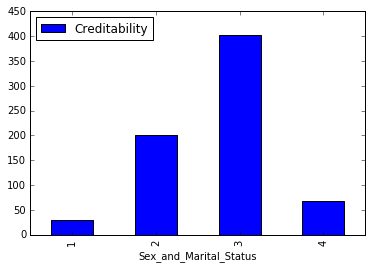

In [130]:
#o bien podemos hacer un grafico de barras
# con el parametro kind lo cambiamos facilmente
no_pagan.groupby('Sex_and_Marital_Status').count().plot(kind='bar')

In [131]:
#agregare un feature de generos riesgosos, en la tabla anterior podemos ver que 
#los clientes que tienen menos creditabilidad estan concentrados en el genero
#que tiene como clave, llave, o id un 3

#df['genero_Riesgoso?'] = np.where(df['Sex_and_Marital_Status']==3,'si','no')
#lo mismo puede hacerse para el proposito, detectar los propositos
#de prestamo peligrosos (i.e. que tipo prestamos son los que menos paga la gente )
df['genero_Riesgoso?'] = np.where(df['Sex_and_Marital_Status']==3,'1','0')

In [132]:
#lo guardamos en un nuevo csv por si queremos usarlo despues
df.to_csv('/Users/user/Desktop/datos_con_nueva_col.csv', index=False)

In [133]:
df[['Creditability', 'Sex_and_Marital_Status', 'genero_Riesgoso?']]

,Creditability,Sex_and_Marital_Status,genero_Riesgoso?
0,1,2,0
1,1,3,1
2,1,2,0
3,1,3,1
4,1,3,1
5,1,3,1
6,1,3,1
7,1,3,1
8,1,2,0
9,1,2,0


In [134]:
#Ahora volvemos a vectorizar y a evaluar, pero con la nueva columna o feature de generos riesgosos
new_data = pd.read_csv('/Users/user/Desktop/datos_con_nueva_col.csv')
new_data.tail()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex_and_Marital_Status,...,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker,genero_Riesgoso?
995,0,1,24,2,3,1987,1,3,2,3,...,1,21,3,1,1,2,2,1,1,1
996,0,1,24,2,0,2303,1,5,4,3,...,1,45,3,2,1,3,1,1,1,1
997,0,4,21,4,0,12680,5,5,4,3,...,4,30,3,3,1,4,1,2,1,1
998,0,2,12,2,3,6468,5,1,2,3,...,4,52,3,2,1,4,1,2,1,1
999,0,1,30,2,2,6350,5,5,4,3,...,2,31,3,2,1,3,1,1,1,1


In [135]:
X_feat1 = new_data.drop("Creditability", axis=1).values
y_feat1 = new_data.Creditability.values

In [136]:
#Hay valores nulos o faltantes?
#df.apply(lambda x: sum(x.isnull()))

In [137]:
perform_classification(X_feat1, y_feat1)

Exactitud 0.82
Fold: 1, distribucion de la clase: [208 511], Acc: 0.765
Fold: 2, distribucion de la clase: [208 511], Acc: 0.741
Fold: 3, distribucion de la clase: [209 511], Acc: 0.838
Fold: 4, distribucion de la clase: [209 511], Acc: 0.762
Fold: 5, distribucion de la clase: [209 511], Acc: 0.662
Fold: 6, distribucion de la clase: [209 511], Acc: 0.750
Fold: 7, distribucion de la clase: [209 511], Acc: 0.725
Fold: 8, distribucion de la clase: [209 511], Acc: 0.787
Fold: 9, distribucion de la clase: [209 512], Acc: 0.797
Fold: 10, distribucion de la clase: [209 512], Acc: 0.810

CV accuracy: 0.763876777622

CV f1-score: 0.843336922736

CV presicion: 0.796780835688

CV recall: 0.897963659148


## Selección de caracteristicas
### Removiendo features con baja varianza

In [138]:
from sklearn.feature_selection import VarianceThreshold
# sobre la matriz original
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_low_variance = sel.fit_transform(X)
X_low_variance.shape

(1000, 18)

In [139]:
perform_classification(X_low_variance, y_feat1)
#Aqui subio a de .81 a .82

Exactitud 0.82
Fold: 1, distribucion de la clase: [208 511], Acc: 0.753
Fold: 2, distribucion de la clase: [208 511], Acc: 0.741
Fold: 3, distribucion de la clase: [209 511], Acc: 0.863
Fold: 4, distribucion de la clase: [209 511], Acc: 0.800
Fold: 5, distribucion de la clase: [209 511], Acc: 0.675
Fold: 6, distribucion de la clase: [209 511], Acc: 0.750
Fold: 7, distribucion de la clase: [209 511], Acc: 0.738
Fold: 8, distribucion de la clase: [209 511], Acc: 0.812
Fold: 9, distribucion de la clase: [209 512], Acc: 0.797
Fold: 10, distribucion de la clase: [209 512], Acc: 0.823

CV accuracy: 0.775158032505

CV f1-score: 0.851193402828

CV presicion: 0.803327976572

CV recall: 0.906735588972


## Con Arboles

In [140]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
print(X.shape)

clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
clf.feature_importances_  


(1000, 20)


array([ 0.12613907,  0.08228563,  0.05769386,  0.05967873,  0.07547315,
        0.05350089,  0.05929689,  0.04640616,  0.03956866,  0.03157755,
        0.05154828,  0.05779876,  0.06187946,  0.0310028 ,  0.03228969,
        0.03344951,  0.04566913,  0.02167057,  0.02546352,  0.00760769])

In [141]:
model = SelectFromModel(clf, prefit=True)
X_with_tree = model.transform(X)
X_with_tree.shape               


(1000, 10)

In [142]:
perform_classification(X_with_tree, y)
#No fue buena idea bajo, nos quedamos con la anterior que hasta el momento ha sido la mas alta
#X_low_variance

Exactitud 0.78
Fold: 1, distribucion de la clase: [208 511], Acc: 0.790
Fold: 2, distribucion de la clase: [208 511], Acc: 0.753
Fold: 3, distribucion de la clase: [209 511], Acc: 0.825
Fold: 4, distribucion de la clase: [209 511], Acc: 0.775
Fold: 5, distribucion de la clase: [209 511], Acc: 0.725
Fold: 6, distribucion de la clase: [209 511], Acc: 0.750
Fold: 7, distribucion de la clase: [209 511], Acc: 0.713
Fold: 8, distribucion de la clase: [209 511], Acc: 0.738
Fold: 9, distribucion de la clase: [209 512], Acc: 0.772
Fold: 10, distribucion de la clase: [209 512], Acc: 0.785

CV accuracy: 0.762517190186

CV f1-score: 0.842281816975

CV presicion: 0.798649469229

CV recall: 0.894266917293


## Con selección univarida de caracteristicas (regresa las k mejores características)

In [143]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_kbest_feats = SelectKBest(chi2, k=2).fit_transform(X, y)
X_kbest_feats.shape

(1000, 2)

In [144]:
perform_classification(X_kbest_feats, y)

Exactitud 0.675
Fold: 1, distribucion de la clase: [208 511], Acc: 0.728
Fold: 2, distribucion de la clase: [208 511], Acc: 0.728
Fold: 3, distribucion de la clase: [209 511], Acc: 0.688
Fold: 4, distribucion de la clase: [209 511], Acc: 0.738
Fold: 5, distribucion de la clase: [209 511], Acc: 0.725
Fold: 6, distribucion de la clase: [209 511], Acc: 0.762
Fold: 7, distribucion de la clase: [209 511], Acc: 0.688
Fold: 8, distribucion de la clase: [209 511], Acc: 0.713
Fold: 9, distribucion de la clase: [209 512], Acc: 0.785
Fold: 10, distribucion de la clase: [209 512], Acc: 0.759

CV accuracy: 0.731359392093

CV f1-score: 0.831521388325

CV presicion: 0.750591797583

CV recall: 0.933176691729


## Con PCA

In [145]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 'mle')
X_pca =pca.fit_transform(X)
PCA(copy=True, n_components='mle', whiten=False)
print(pca.explained_variance_ratio_) 

[  9.99970189e-01   1.63787047e-05   1.09773200e-05   9.25511192e-07
   3.41920585e-07   2.01780396e-07   1.90290312e-07   1.40272907e-07
   1.31663275e-07   1.25395818e-07   1.06243259e-07   6.46908565e-08
   5.74597394e-08   4.72993488e-08   2.98590092e-08   2.67436022e-08
   2.58079874e-08   2.11450315e-08   1.48832929e-08]


In [146]:
perform_classification(X_pca, y)

Exactitud 0.775
Fold: 1, distribucion de la clase: [208 511], Acc: 0.741
Fold: 2, distribucion de la clase: [208 511], Acc: 0.741
Fold: 3, distribucion de la clase: [209 511], Acc: 0.787
Fold: 4, distribucion de la clase: [209 511], Acc: 0.738
Fold: 5, distribucion de la clase: [209 511], Acc: 0.738
Fold: 6, distribucion de la clase: [209 511], Acc: 0.825
Fold: 7, distribucion de la clase: [209 511], Acc: 0.738
Fold: 8, distribucion de la clase: [209 511], Acc: 0.750
Fold: 9, distribucion de la clase: [209 512], Acc: 0.759
Fold: 10, distribucion de la clase: [209 512], Acc: 0.772

CV accuracy: 0.75881270511

CV f1-score: 0.842401022721

CV presicion: 0.787609135998

CV recall: 0.908521303258


## Con Truncated SVD (LSA)

In [147]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
#X = sparse_random_matrix(100, 100, density=0.01, random_state=42)
svd = TruncatedSVD(n_components=3, random_state=False)
X_svd = svd.fit_transform(X) 
X_svd.shape

(1000, 3)

In [148]:
perform_classification(X_svd, y)

Exactitud 0.625
Fold: 1, distribucion de la clase: [208 511], Acc: 0.691
Fold: 2, distribucion de la clase: [208 511], Acc: 0.667
Fold: 3, distribucion de la clase: [209 511], Acc: 0.700
Fold: 4, distribucion de la clase: [209 511], Acc: 0.675
Fold: 5, distribucion de la clase: [209 511], Acc: 0.662
Fold: 6, distribucion de la clase: [209 511], Acc: 0.762
Fold: 7, distribucion de la clase: [209 511], Acc: 0.700
Fold: 8, distribucion de la clase: [209 511], Acc: 0.725
Fold: 9, distribucion de la clase: [209 512], Acc: 0.722
Fold: 10, distribucion de la clase: [209 512], Acc: 0.734

CV accuracy: 0.703872089389

CV f1-score: 0.81864372179

CV presicion: 0.72439777268

CV recall: 0.942011278195


## Nota

Al parecer los métodos anteriores fueron muy agresivos, nos quedamos con la matriz `X_low_variance`.

## GridSearch

In [150]:
from sklearn.grid_search import GridSearchCV

xgb_model = XGBClassifier()

#Un diccionario de hiper parametros para probar
parameters = {
    'n_estimators': [800, 900, 1000],
    'learning_rate': [0.005, 0.05, 0.1, 0.3, .5, 1, 2],
    'max_depth': [6, 8, 10],
    'subsample': [0.5, .75, 1],
    'colsample_bytree': [0.4, .6, .8, 1.0],
    'gamma':[0, .1, .5, 1]
}

X_train, X_test, y_train, y_test = \
train_test_split(X_low_variance, y, test_size=0.20, random_state=False) 

clf_grid = GridSearchCV(xgb_model, parameters, verbose=0, n_jobs=-1, scoring='accuracy')
clf_grid.fit(X_train, y_train)


#print('\nGrid scores:',clf.grid_scores_)
print ('\nMejor score:\n', clf_grid.best_score_)
print ('\nMejores hiper-parametros:\n', clf_grid.best_params_)
print ('best estimator',clf_grid.best_estimator_)


Mejor score:
 0.7775

Mejores hiper-parametros:
 {'gamma': 0, 'max_depth': 6, 'n_estimators': 1000, 'learning_rate': 0.005, 'colsample_bytree': 0.4, 'subsample': 1}
best estimator XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


# Con algoritmos geneticos (Tpot)



In [ ]:
from tpot import TPOT

X_train, X_test, y_train, y_test =train_test_split(
    X_low_variance, y, test_size=0.20, random_state=False) 

tpot = TPOT(generations=5)

tpot.fit(X_train,y_train)
print(tpot.score(X_test,y_test))
tpot.export(('/Users/user/Desktop/t_pot_pipeline_loan.py'))

## Conclusión 1

Al parecer nos conviene quedarnos con la matriz de baja varianza (`X_low_variance`). Veamos como se comporta, revisemos su **matriz de confusión**:


In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_low_variance, y, test_size=0.20, random_state=False)
    
best_pipe = make_pipeline(XGBClassifier())
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
print('Exactitud', best_pipe.score(X_test, y_test))

Exactitud 0.82


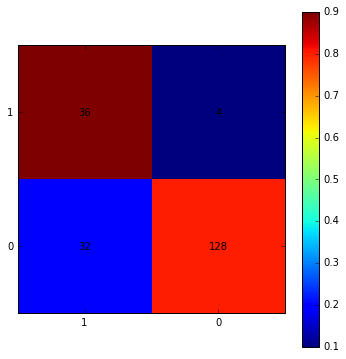

In [82]:
confusion_mat=confusion_matrix(y_pred, y_test)
norm_conf = []
for i in confusion_mat:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure(figsize=(6, 6))
plt.clf()
ax = fig.add_subplot(111)

ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = confusion_mat.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(confusion_mat[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
alphabet = df.Creditability.unique()
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.savefig('/Users/user/Desktop/loan_cf_mat.png', format='png')

## Serializando y guardando el modelo que aprendimos

Una vez que entrenamos y logramos el rendiemiento deseado, serializaremos el modelo para poder usarlo solo para predecir nuevas instancias de datos nunca antes vistas (i.e. predecir si pagan o no pagan nuevos clientes). 

Al no tener más datos tomaré una muestra aleatoria a partir de nuestro dataset solo con la finalidad de mostrar como se haría en un ambiente más real.


In [91]:
#primero extraemos una muestra, aleatoriamente 
#extraemos el 20% de datos del dataframe
df_test = df.sample(frac=0.2, random_state=0)
df_test.head(3)
#Generamos nuesra X
X_random_sample_test = df_test.drop('Creditability', axis=1).values
X_random_sample_test

array([[1, 18, 4, ..., 2, 1, '0'],
       [1, 12, 2, ..., 2, 1, '0'],
       [2, 12, 2, ..., 1, 1, '0'],
       ..., 
       [3, 10, 2, ..., 1, 1, '1'],
       [4, 24, 4, ..., 1, 1, '1'],
       [3, 12, 1, ..., 1, 1, '0']], dtype=object)

In [86]:
#lo guardamos
from sklearn.externals import joblib
joblib.dump(best_pipe,'/Users/user/Desktop/loan_prediction_model.pkl') 

['/Users/user/Desktop/loan_prediction_model.pkl',
 '/Users/user/Desktop/loan_prediction_model.pkl_01.npy']

In [95]:
#y lo vovlemos a cargar
serialized_clf = joblib.load('/Users/user/Desktop/loan_prediction_model.pkl') 
#clasificamos ya con el modelo entrenado
predictions = serialized_clf.predict(X_random_sample_test)

In [99]:
df_test['predictions'] = predictions
df_test[['Creditability', 'predictions']]

,Creditability,predictions
993,0,1
859,0,0
298,1,1
553,1,1
672,1,1
971,0,0
27,1,1
231,1,1
306,1,1
706,1,1


# Extra
## Con Keras (deep learning)

In [ ]:
from keras.models import Sequential
from sklearn.cross_validation import StratifiedKFold
import numpy
from keras.layers import Dense
# fijamos para reproductibilidad
seed = 7
numpy.random.seed(seed)

kfold = StratifiedKFold(y=y, n_folds=10, shuffle=True, random_state=seed)
cvscores = []
for i, (train, test) in enumerate(kfold):
    # instaciamos el modelo
    model = Sequential()
    model.add(Dense(12, input_dim=20, init='uniform', activation='relu'))
    model.add(Dense(20, init='uniform', activation='relu'))
    model.add(Dense(1, init='uniform', activation='sigmoid'))
    # compilamos el modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # hacemos fit
    model.fit(X[train], y[train], nb_epoch=150, batch_size=10, verbose=0)
    #evaluacion
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print ("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))